In [7]:
### Importing libraries

import numpy as np


import matplotlib.pyplot as plt
%matplotlib notebook

import pickle

import time



In [8]:
with open('Cine Pickles/patient_numbers.pickle', 'rb') as handle:
    pat_nums = pickle.load(handle)
    
with open('Cine Pickles/pat_num_2_frac_nums.pickle', 'rb') as handle:
    pat_num_2_frac_nums = pickle.load(handle)
    
    
with open('Cine Pickles/MR_res_2_pixel_size.pickle', 'rb') as handle:
    MR_res_2_pixel_size = pickle.load(handle)
    
    
with open('Cine Pickles/zero_target_contour_pixel_coodrinates.pickle', 'rb') as handle:
    zero_target_contour_pixel_coodrinates = pickle.load(handle)
    

In [11]:

for pat_num in [1,6]:#pat_nums:

    for frac_num in range(1, pat_num_2_frac_nums[pat_num] + 1):
        
        

        print( '------>' + str(pat_num) + ' , ' + str(frac_num))







#cine_video_name = 'pat_' + str(pat_num) + '_frac_' + str(frac_num) + '.ogv'

# for number in [1]:
    
#     cine_video_name = 'phantom ' + str(number) + '.ogv' 
    
#     print(cine_video_name)
        


        #cine_video_name = 'phantom 1.ogv'


        with open('Cine Pickles/' + cine_video_name + '/cine_res.pickle', 'rb') as handle:
            cine_res = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/cine_fps.pickle', 'rb') as handle:
            cine_fps = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/MR_res.pickle', 'rb') as handle:
            MR_res = pickle.load(handle)

        with open('Cine Pickles/' + cine_video_name + '/MR_pixel.pickle', 'rb') as handle:
            MR_pixel = pickle.load(handle)


        pixel_size = MR_res_2_pixel_size[MR_res]




        with open('Cine Pickles/' + cine_video_name + '/number_of_minutes.pickle', 'rb') as handle:
            number_of_minutes = pickle.load(handle)


        total_no_of_frames = 0


        for minute_number in np.arange(1, number_of_minutes + 2, 2 , dtype = 'int'):

            with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) +'/no_of_frames.pickle', 'rb') as handle:
                no_of_frames = pickle.load(handle)

            total_no_of_frames += no_of_frames

        frame_nums = np.arange(0, total_no_of_frames, 1)  


        with open('Cine Pickles/' + cine_video_name + '/frame_nums.pickle', 'wb') as handle:
            pickle.dump(frame_nums, handle, protocol=pickle.HIGHEST_PROTOCOL)



        ####First search for errors - see if there is no target contour in any frames



        error_frames = []




        ########==================================================================



        All_Frames_Target_Pixel_Coordinates = []


        for minute_number  in np.arange(1, number_of_minutes +2 , 2 , dtype = 'int'):

            #print(minute_number)


            with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) +'/Frames_Target_Pixel_Coordinates.pickle', 'rb') as handle:
                Frames_Target_Pixel_Coordinates = pickle.load(handle)


            frame = 0

            for target_pixel_coordinates in Frames_Target_Pixel_Coordinates:


                All_Frames_Target_Pixel_Coordinates.append(target_pixel_coordinates)


                if len(target_pixel_coordinates) == len(zero_target_contour_pixel_coodrinates):

                    error_frames.append( int( (1/2)*(minute_number - 1)*960 + frame ) )


                frame += 1


        ##########=================================================



        ############ Defining a perimeter

        frames_areas = []

        frames_perimeter_lengths = []

        frames_perimeter_coordinates = []


        for frame_num in frame_nums:

            #if frame_num % 1000 == 0:

                #print(frame_num)


            target_array = np.zeros((cine_res,cine_res))

            perimeter_length = 0

            perimeter_coordinates = []

            area = 0


            for coordinate in All_Frames_Target_Pixel_Coordinates[frame_num]:

                x = coordinate[0]

                y = coordinate[1]

                target_array[y,x] = 1

                area += 1


            for coordinate in All_Frames_Target_Pixel_Coordinates[frame_num]:    


                neighbour_pixels_sum = np.sum( target_array[ coordinate[1] - 1 : coordinate[1] + 2     ,    coordinate[0] - 1  : coordinate[0] + 2])

                if (neighbour_pixels_sum != 9):

                    perimeter_length += 1

                    perimeter_coordinates.append(coordinate)


            perimeter_coordinates = np.array(perimeter_coordinates)

            frames_perimeter_coordinates.append(perimeter_coordinates)


            frames_areas.append(area)


            frames_perimeter_lengths.append(perimeter_length)





        frames_areas = np.array(frames_areas)

        frames_perimeter_lengths = np.array(frames_perimeter_lengths)





        ####################################################################################






        frames_ratios = frames_perimeter_lengths/(frames_areas**(1/2))



        ratio_mean = np.mean(frames_ratios)

        ratio_std = np.std(frames_ratios)



        errors = np.where( (frames_ratios - ratio_mean) > 3*ratio_std )

        errors = list(errors[0])


        error_frames = sorted( list( set(error_frames + errors) ) )


        #print(error_frames)


        #         plt.figure()

        #         plt.scatter(frame_nums, frames_ratios , alpha = 0.1)


        #         plt.scatter(  error_frames , [frames_ratios[error_frame] for error_frame in error_frames ] , color = 'tab:red' )



        #         plt.figure()

        #         plt.scatter(frame_nums, frames_areas , alpha = 0.1)


        #         plt.scatter(  error_frames , [frames_areas[error_frame] for error_frame in error_frames ] , color = 'tab:red' )






        #         plt.figure()

        #         plt.scatter(frame_nums, frames_areas)


        #         plt.scatter(  error_frames , [frames_areas[error_frame] for error_frame in error_frames] , color =  'tab:red' )


        #print( len(error_frames))

        error_rate =  100*round(len(error_frames)/len(frame_nums) , 4)

        with open('Cine Pickles/' + cine_video_name + '/error_rate_from_target_contour_extraction.pickle', 'wb') as handle:
            pickle.dump(error_rate, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open('Cine Pickles/' + cine_video_name + '/error_frames_from_target_contour_extraction.pickle', 'wb') as handle:
            pickle.dump(error_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

        print( 'error rate: ' + str(error_rate) + ' %' )



        time.sleep(20)


------>1 , 1
error rate: 0.24 %
------>1 , 2
error rate: 0.24 %
------>1 , 3
error rate: 0.24 %
------>1 , 4
error rate: 0.24 %
------>1 , 5
error rate: 0.24 %
------>6 , 1
error rate: 0.24 %
------>6 , 2
error rate: 0.24 %
------>6 , 3
error rate: 0.24 %
------>6 , 4
error rate: 0.24 %


In [25]:
print(All_Frames_Target_Pixel_Coordinates[107])

print(zero_target_contour_pixel_coodrinates)


len(All_Frames_Target_Pixel_Coordinates[107]) == len(zero_target_contour_pixel_coodrinates)

[[ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 0 25]
 [ 0 26]
 [ 0 27]]
[[ 0  1]
 [ 0  2]
 [ 0  3]
 [ 0  4]
 [ 0  5]
 [ 0  6]
 [ 0  7]
 [ 0  8]
 [ 0  9]
 [ 0 10]
 [ 0 11]
 [ 0 12]
 [ 0 13]
 [ 0 14]
 [ 0 15]
 [ 0 16]
 [ 0 17]
 [ 0 18]
 [ 0 19]
 [ 0 20]
 [ 0 21]
 [ 0 22]
 [ 0 23]
 [ 0 24]
 [ 0 25]
 [ 0 26]
 [ 0 27]]


True

In [5]:
error_frames

[492,
 596,
 667,
 834,
 1369,
 1451,
 1562,
 1794,
 1795,
 1809,
 1866,
 1968,
 2105,
 2186,
 2254,
 2629,
 3678,
 3724,
 5279,
 5890,
 6905,
 6952,
 8087,
 8171,
 8233,
 8364,
 8440,
 8646,
 9106,
 9174,
 9226,
 9555,
 9556,
 9706,
 9887,
 9888,
 9889,
 9898,
 9899,
 9900,
 9908,
 9912,
 9920,
 9937,
 9950,
 9952,
 9957,
 9964,
 9969,
 9970,
 9971,
 9972,
 9973,
 9991,
 9994,
 9995,
 9996,
 9997,
 9998,
 9999,
 10000,
 10002,
 10003,
 10004,
 10005,
 10006,
 10007,
 10008,
 10010,
 10013,
 10015,
 10016,
 10017,
 10018,
 10019,
 10024,
 10026,
 10027,
 10030,
 10033,
 10034,
 10035,
 10036,
 10043,
 10044,
 10045,
 10046,
 10047,
 10048,
 10049,
 10054,
 10055]

In [7]:
cine_video_name = 'pat_4_frac_2.ogv'


with open('Cine Pickles/' + cine_video_name + '/error_frames.pickle', 'rb') as handle:
    error_frames = pickle.load(handle)
    

    
print(error_frames)
# error_frames = [1,2,3,4,5,5]
    
    
seto = set(error_frames)

print(sorted(list(seto)) )

print( len(seto) - len(error_frames) )

[0, 1, 42, 43, 44, 127, 238, 621, 1587, 1588, 1597, 1927, 1928, 1929, 1930, 1942, 1953, 1954, 1955, 1957, 2205, 2206, 2207, 2276, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2592, 2758]
[0, 1, 42, 43, 44, 127, 238, 621, 1587, 1588, 1597, 1927, 1928, 1929, 1930, 1942, 1953, 1954, 1955, 1957, 2205, 2206, 2207, 2276, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2592, 2758]
0


<IPython.core.display.Javascript object>


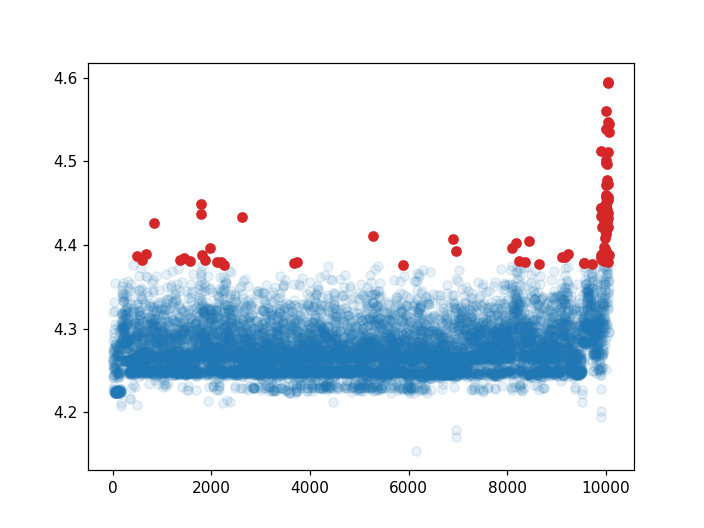

<IPython.core.display.Javascript object>


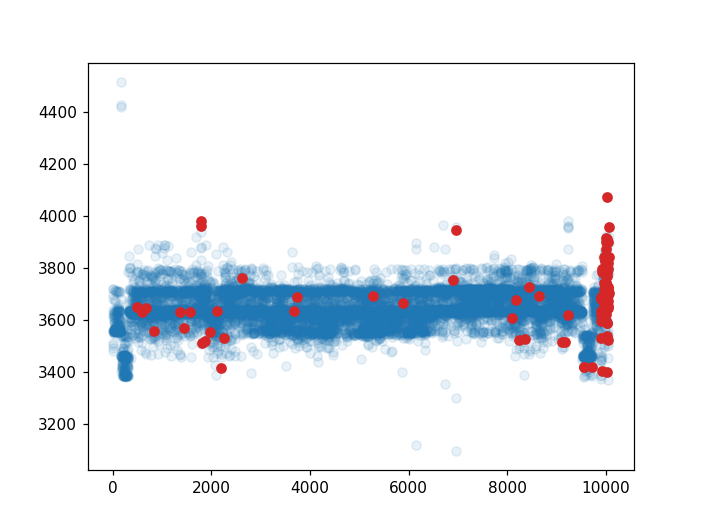

[492, 596, 667, 834, 1369, 1451, 1562, 1794, 1795, 1809, 1866, 1968, 2105, 2186, 2254, 2629, 3678, 3724, 5279, 5890, 6905, 6952, 8087, 8171, 8233, 8364, 8440, 8646, 9106, 9174, 9226, 9555, 9556, 9706, 9887, 9888, 9889, 9898, 9899, 9900, 9908, 9912, 9920, 9937, 9950, 9952, 9957, 9964, 9969, 9970, 9971, 9972, 9973, 9991, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10002, 10003, 10004, 10005, 10006, 10007, 10008, 10010, 10013, 10015, 10016, 10017, 10018, 10019, 10024, 10026, 10027, 10030, 10033, 10034, 10035, 10036, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10054, 10055]


In [6]:

plt.figure()

plt.scatter(frame_nums, frames_ratios , alpha = 0.1)


plt.scatter(  error_frames , [frames_ratios[error_frame] for error_frame in error_frames ] , color = 'tab:red' )



plt.figure()

plt.scatter(frame_nums, frames_areas , alpha = 0.1)


plt.scatter(  error_frames , [frames_areas[error_frame] for error_frame in error_frames ] , color = 'tab:red' )


print(error_frames)

<IPython.core.display.Javascript object>


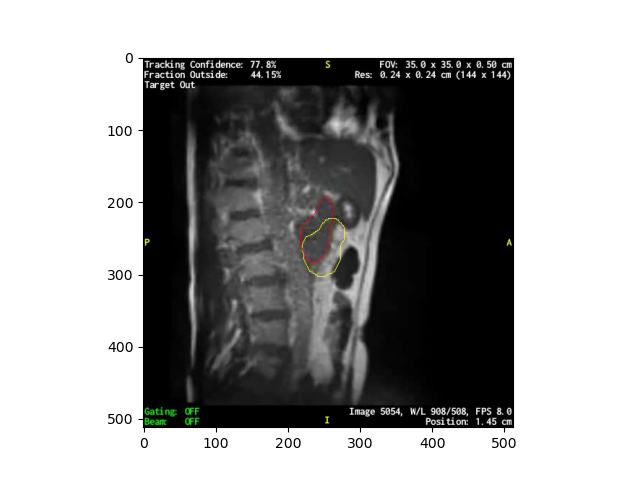

<IPython.core.display.Javascript object>


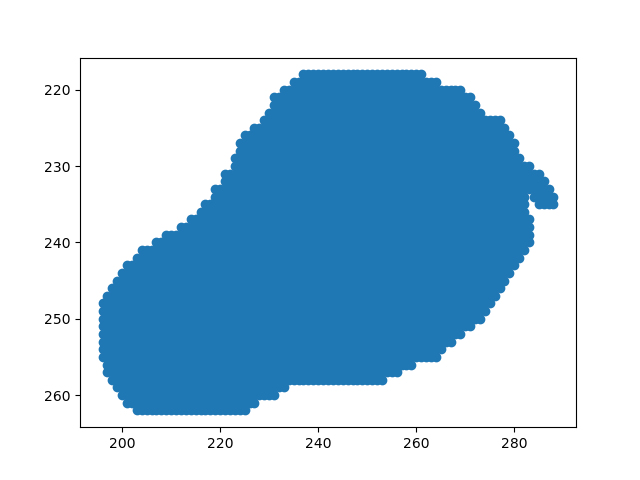

In [11]:
frame_num = 5054
cine_image = plt.imread('Cine frames/' + cine_video_name + '/frame-%04d.png' % frame_num )


plt.figure()

plt.imshow(cine_image)





plt.figure()

plt.scatter(  All_Frames_Target_Pixel_Coordinates[frame_num][:,1] , All_Frames_Target_Pixel_Coordinates[frame_num][:,0])

#plt.scatter(  Inside_Boundary_Pixel_Coordinates[:,1] , Inside_Boundary_Pixel_Coordinates[:,0], alpha = 0.2)

plt.gca().invert_yaxis()

In [33]:
cine_video_name = 'pat_' + str(pat_num) + '_frac_' + str(frac_num) + '.ogv'

#cine_video_name = 'ZZZZZ, Modus4D  - Fraction3 - 1.ogv'


with open('Cine Pickles/' + cine_video_name + '/cine_res.pickle', 'rb') as handle:
    cine_res = pickle.load(handle)
    
with open('Cine Pickles/' + cine_video_name + '/cine_fps.pickle', 'rb') as handle:
    cine_fps = pickle.load(handle)
    
with open('Cine Pickles/' + cine_video_name + '/MR_res.pickle', 'rb') as handle:
    MR_res = pickle.load(handle)
    
with open('Cine Pickles/' + cine_video_name + '/MR_pixel.pickle', 'rb') as handle:
    MR_pixel = pickle.load(handle)
    
    
with open('Cine Pickles/' + cine_video_name + '/number_of_minutes.pickle', 'rb') as handle:
    number_of_minutes = pickle.load(handle)
    
    
total_no_of_frames = 0


for minute_number in np.arange(1, number_of_minutes + 2, 2 , dtype = 'int'):
    
    with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) +'/no_of_frames.pickle', 'rb') as handle:
        no_of_frames = pickle.load(handle)
        
    total_no_of_frames += no_of_frames
    
frame_nums = np.arange(0, total_no_of_frames, 1)  

    
with open('Cine Pickles/' + cine_video_name + '/frame_nums.pickle', 'wb') as handle:
    pickle.dump(frame_nums, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [34]:
All_Frames_Target_Pixel_Coordinates = []


for minute_number  in np.arange(1, number_of_minutes +2 , 2 , dtype = 'int'):
    
    #print(minute_number)


    with open('Cine Pickles/' + cine_video_name + '/minute ' + str(minute_number) +'/Frames_Target_Pixel_Coordinates.pickle', 'rb') as handle:
        Frames_Target_Pixel_Coordinates = pickle.load(handle)
     
    
    for frame in Frames_Target_Pixel_Coordinates:
    
    
        All_Frames_Target_Pixel_Coordinates.append(frame)
        
        
#print(All_Frames_Target_Pixel_Coordinates)

In [44]:
############ Defining a perimeter

frames_areas = []

frames_perimeter_lengths = []

frames_perimeter_coordinates = []


for frame_num in frame_nums:
    
    if frame_num % 100 == 0:
        
        print(frame_num)


    target_array = np.zeros((cine_res,cine_res))

    perimeter_length = 0

    perimeter_coordinates = []

    area = 0


    for coordinate in All_Frames_Target_Pixel_Coordinates[frame_num]:

        x = coordinate[0]

        y = coordinate[1]

        target_array[y,x] = 1

        area += 1


    for coordinate in All_Frames_Target_Pixel_Coordinates[frame_num]:    


        neighbour_pixels_sum = np.sum( target_array[ coordinate[1] - 1 : coordinate[1] + 2     ,    coordinate[0] - 1  : coordinate[0] + 2])

        if (neighbour_pixels_sum != 9):

            perimeter_length += 1

            perimeter_coordinates.append(coordinate)


    perimeter_coordinates = np.array(perimeter_coordinates)
    
    frames_perimeter_coordinates.append(perimeter_coordinates)
    
    
    frames_areas.append(area)
    
    
    frames_perimeter_lengths.append(perimeter_length)
    
    

    
    
frames_areas = np.array(frames_areas)

frames_perimeter_lengths = np.array(frames_perimeter_lengths)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000


<IPython.core.display.Javascript object>


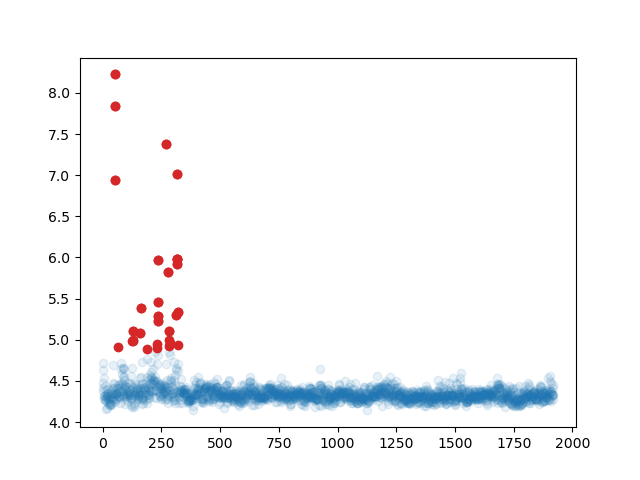

<IPython.core.display.Javascript object>


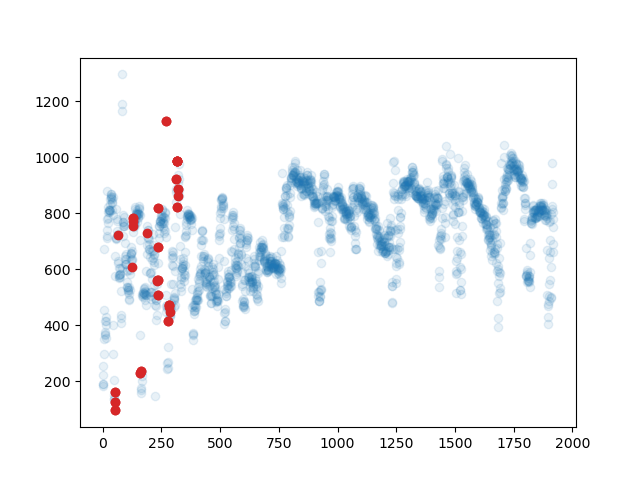

<IPython.core.display.Javascript object>


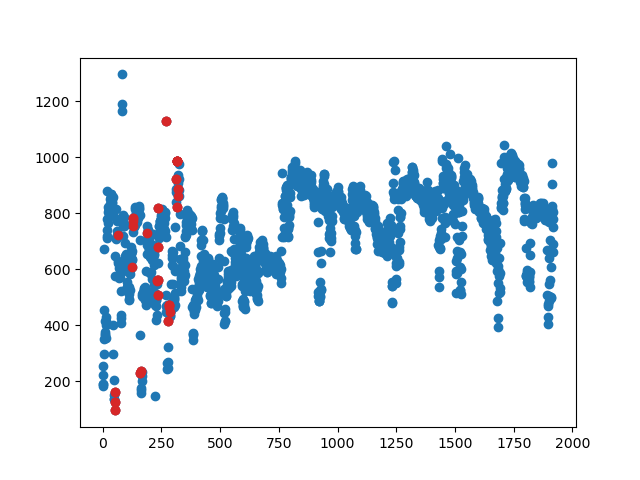

error rate: 0.0255%


In [74]:
frames_ratios = frames_perimeter_lengths/(frames_areas**(1/2))



ratio_mean = np.mean(frames_ratios)

ratio_std = np.std(frames_ratios)



errors = np.where( (frames_ratios - ratio_mean) > 2.5*ratio_std )


error_frames = error_frames + list(errors[0])





plt.figure()

plt.scatter(frame_nums, frames_ratios , alpha = 0.1)


plt.scatter(  error_frames , [frames_ratios[error_frame] for error_frame in error_frames ] , color = 'tab:red' )



plt.figure()

plt.scatter(frame_nums, frames_areas , alpha = 0.1)


plt.scatter(  error_frames , [frames_areas[error_frame] for error_frame in error_frames ] , color = 'tab:red' )






plt.figure()

plt.scatter(frame_nums, frames_areas)


plt.scatter(  error_frames , [frames_areas[error_frame] for error_frame in error_frames] , color =  'tab:red' )



error_rate =  round(len(error_frames)/len(frame_nums) , 4)

with open('Cine Pickles/' + cine_video_name + '/contour_extraction_error_rate.pickle', 'wb') as handle:
    pickle.dump(error_rate, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    
with open('Cine Pickles/' + cine_video_name + '/error_frames.pickle', 'wb') as handle:
    pickle.dump(error_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

print( 'error rate: ' + str(error_rate) + '%')


In [66]:
error_frames

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 429,
 430,
 434,
 436,
 439,
 440,
 467,
 470,
 471,
 473,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 836,
 428,
 429,
 430,
 434,
 435,
 436,
 437,
 438,
 439,
 440,
 441,
 442,
 447,
 458,
 465,
 466,
 467,
 470,
 471,
 472,
 473,
 474,
 475,
 476,
 477,
 478,
 479,
 480,
 481,
 482,
 483,
 484,
 485,
 486,
 487,
 488,
 489,
 507,
 836]

<IPython.core.display.Javascript object>


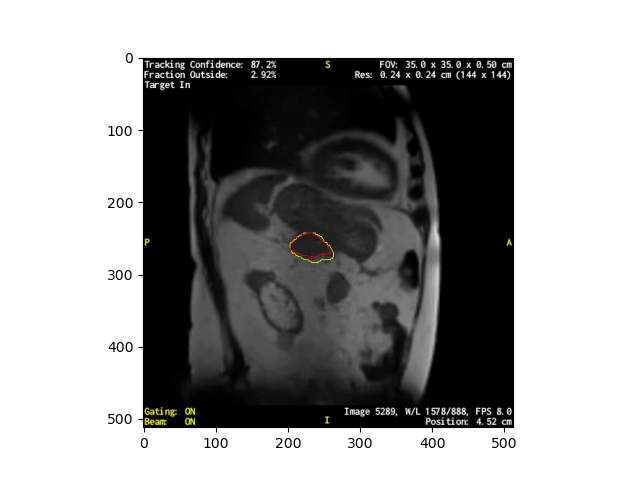

<IPython.core.display.Javascript object>


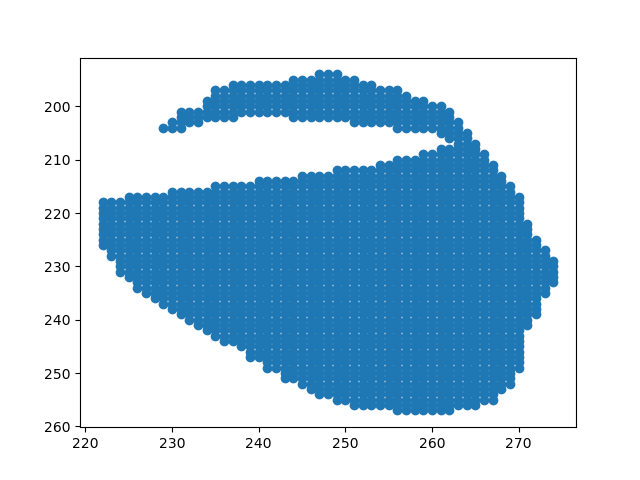

In [79]:
frame_num = 5289

cine_image = plt.imread('Cine frames/' + cine_video_name + '/frame-%04d.png' % frame_num )


plt.figure()

plt.imshow(cine_image)





plt.figure()

plt.scatter(  All_Frames_Target_Pixel_Coordinates[frame_num][:,1] , All_Frames_Target_Pixel_Coordinates[frame_num][:,0])

#plt.scatter(  Inside_Boundary_Pixel_Coordinates[:,1] , Inside_Boundary_Pixel_Coordinates[:,0], alpha = 0.2)

plt.gca().invert_yaxis()

In [10]:
with open('Cine Pickles/' + cine_video_name + '/error_frames.pickle', 'wb') as handle:
    pickle.dump(error_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)